# Assignment #3 (demo)
## Decision trees with a toy task and the UCI Adult dataset

[Link](https://mlcourse.ai/book/topic03/assignment03_decision_trees.html#assignment03)

## Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [2]:
print('Version:')
print(f'numpy: {np.__version__}')
print(f'pandas: {pd.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'sklearn: {sklearn.__version__}')

Version:
numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.8.4
seaborn: 0.13.2
sklearn: 1.4.2


## Part 1. Toy dataset “Will They? Won’t They?”

In [3]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [4]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

### Training data

In [5]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,True,False,False,True,False,True,False,False,True
1,1,True,False,False,True,False,False,True,True,False
2,0,True,False,True,False,True,False,False,False,True
3,1,False,True,True,False,True,False,False,True,False
4,1,False,True,False,True,False,False,True,False,True
5,0,False,True,False,True,False,True,False,False,True
6,0,True,False,False,True,True,False,False,False,True


### Test data

In [6]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,True,False,True,False,True,False,False,True
1,True,False,False,True,False,True,True,False
2,False,True,False,True,True,False,False,True


In [7]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train[["Will_go"]]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Alcoholic_beverage_yes,Money_spent_little,Alcoholic_beverage_no,Eloquence_high,Looks_handsome,Looks_repulsive,Money_spent_lots,Eloquence_average
0,True,False,False,True,True,False,True,False
1,True,True,False,False,True,False,False,False
2,False,False,True,False,True,False,True,True
3,False,True,True,False,False,True,False,True
4,True,False,False,False,False,True,True,False
5,True,False,False,True,False,True,True,False
6,True,False,False,False,True,False,True,True


In [8]:
df_test

,Alcoholic_beverage_yes,Money_spent_little,Alcoholic_beverage_no,Eloquence_high,Looks_handsome,Looks_repulsive,Money_spent_lots,Eloquence_average
0,False,False,True,False,True,False,True,True
1,True,True,False,True,True,False,False,False
2,True,False,False,False,False,True,True,True


### Draw a decision tree (by hand or in any graphics editor) for this dataset.
Optionally you can also implement tree construction and draw it here.

1. What is the entropy $S_0$ of the initial system? By system states, we mean values of the binary feature “Will_go” - 0 or 1 - two states in total.

In [9]:
n = y.shape[0]
y_s0 = y.values
p_1 = y_s0.sum() / n
p_0 = 1 - p_1

In [10]:
s_0 = -p_0 * np.log2(p_0) - p_1 * np.log2(p_1)
s_0

0.9852281360342515

2. Let’s split the data by the feature “Looks_handsome”. What is the entropy 
of the left group - the one with “Looks_handsome”. What is the entropy 
in the opposite group? What is the information gain (IG) if we consider such a split?

In [11]:
y_s1 = y.loc[df_train.query('Looks_handsome == 0').index, 'Will_go'].values
y_s2 = y.loc[df_train.query('Looks_handsome == 1').index, 'Will_go'].values

p_1_s1 = y_s1.sum() / y_s1.shape[0]
p_1_s2 = y_s2.sum() / y_s2.shape[0]

p_0_s1 = 1 - p_1_s1
p_0_s2 = 1 - p_1_s2

s_1 = -p_0_s1 * np.log2(p_0_s1) - p_1_s1 * np.log2(p_1_s1)
s_2 = -p_0_s2 * np.log2(p_0_s2) - p_1_s2 * np.log2(p_1_s2)

ig = s_0 - (y_s1.shape[0] / n) * s_1 - (y_s2.shape[0] / n) * s_2

print(f'S_0: {s_0:.2f}')
print(f'S_1: {s_1:.2f}')
print(f'S_2: {s_2:.2f}')
print(f'IG: {ig:.2f}')

S_0: 0.99
S_1: 0.92
S_2: 0.81
IG: 0.13


### Train a decision tree using sklearn on the training data. You may choose any depth for the tree

In [12]:
cols = ['Money_spent_lots', 'Looks_handsome', 'Eloquence_high', 'Alcoholic_beverage_yes']

clf_tree = DecisionTreeClassifier(
    criterion="entropy",
    #max_depth=5,
    random_state=17
)
clf_tree.fit(df_train[cols], y.values)

DecisionTreeClassifier(criterion='entropy', random_state=17)

### Additional: display the resulting tree using graphviz. You can use pydot or a web-service, e.g. this one

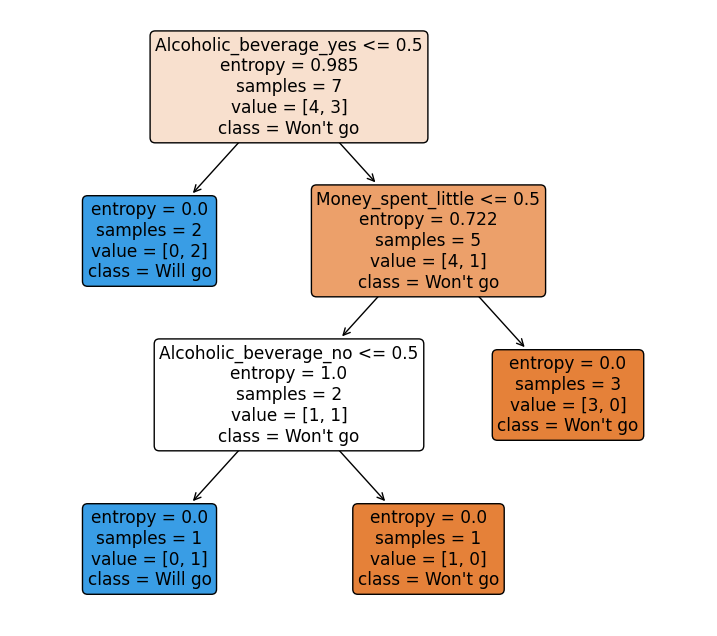

In [13]:
plt.figure(figsize=(9, 8), dpi=100)
plot_tree(clf_tree, feature_names=df_train.columns, filled=True, rounded=True, class_names=["Won't go", "Will go"])
plt.show()

## Part 2. Functions for calculating entropy and information gain

Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let ball have label 1 if it is blue, 0 otherwise.

In [14]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

### Implement a function to calculate the Shannon Entropy

In [16]:
def entropy(a_list):
    _, counts = np.unique(a_list, return_counts=True)
    p = counts / len(a_list)
    return - np.sum(p * np.log2(p))

3. What is the entropy of the state given by the list balls_left?

4. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?

In [17]:
print(entropy(balls))  # 9 blue и 11 yellow
print(entropy(balls_left))  # 8 blue и 5 yellow
print(entropy(balls_right))  # 1 blue и 6 yellow
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


5. What is the information gain from splitting the initial dataset into balls_left and balls_right ?

In [18]:
# information gain calculation
def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""

    n = len(root)
    n_left = len(left)
    n_right = len(right)
    
    s_0 = entropy(root)
    s_1 = entropy(left)
    s_2 = entropy(right)
    
    return s_0 - (n_left / n) * s_1 - (n_right / n) * s_2

In [19]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

## Part 3. The “Adult” dataset

**Dataset description:**

Dataset UCI Adult (no need to download it, we have a copy in the course repository): classify people using demographic data - whether they earn more than $50,000 per year or not.

Feature descriptions:

- `Age` – continuous feature
- `Workclass` – continuous feature
- `fnlwgt` – final weight of object, continuous feature
- `Education` – categorical feature
- `Education_Num` – number of years of education, continuous feature
- `Martial_Status` – categorical feature
- `Occupation` – categorical feature
- `Relationship` – categorical feature
- `Race` – categorical feature
- `Sex` – categorical feature
- `Capital_Gain` – continuous feature
- `Capital_Loss` – continuous feature
- `Hours_per_week` – continuous feature
- `Country` – categorical feature

**Target** – earnings level, categorical (binary) feature.

### Reading train and test data

In [20]:
data_train = pd.read_csv('../../data/adult-train.csv', sep=";")
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [21]:
data_test = pd.read_csv('../../data/adult-test.csv', sep=";")
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [22]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]

# encode target variable as integer
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

### Primary data analysis

In [23]:
data_test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_train["Target"].value_counts()

Target
0    24720
1     7841
Name: count, dtype: int64

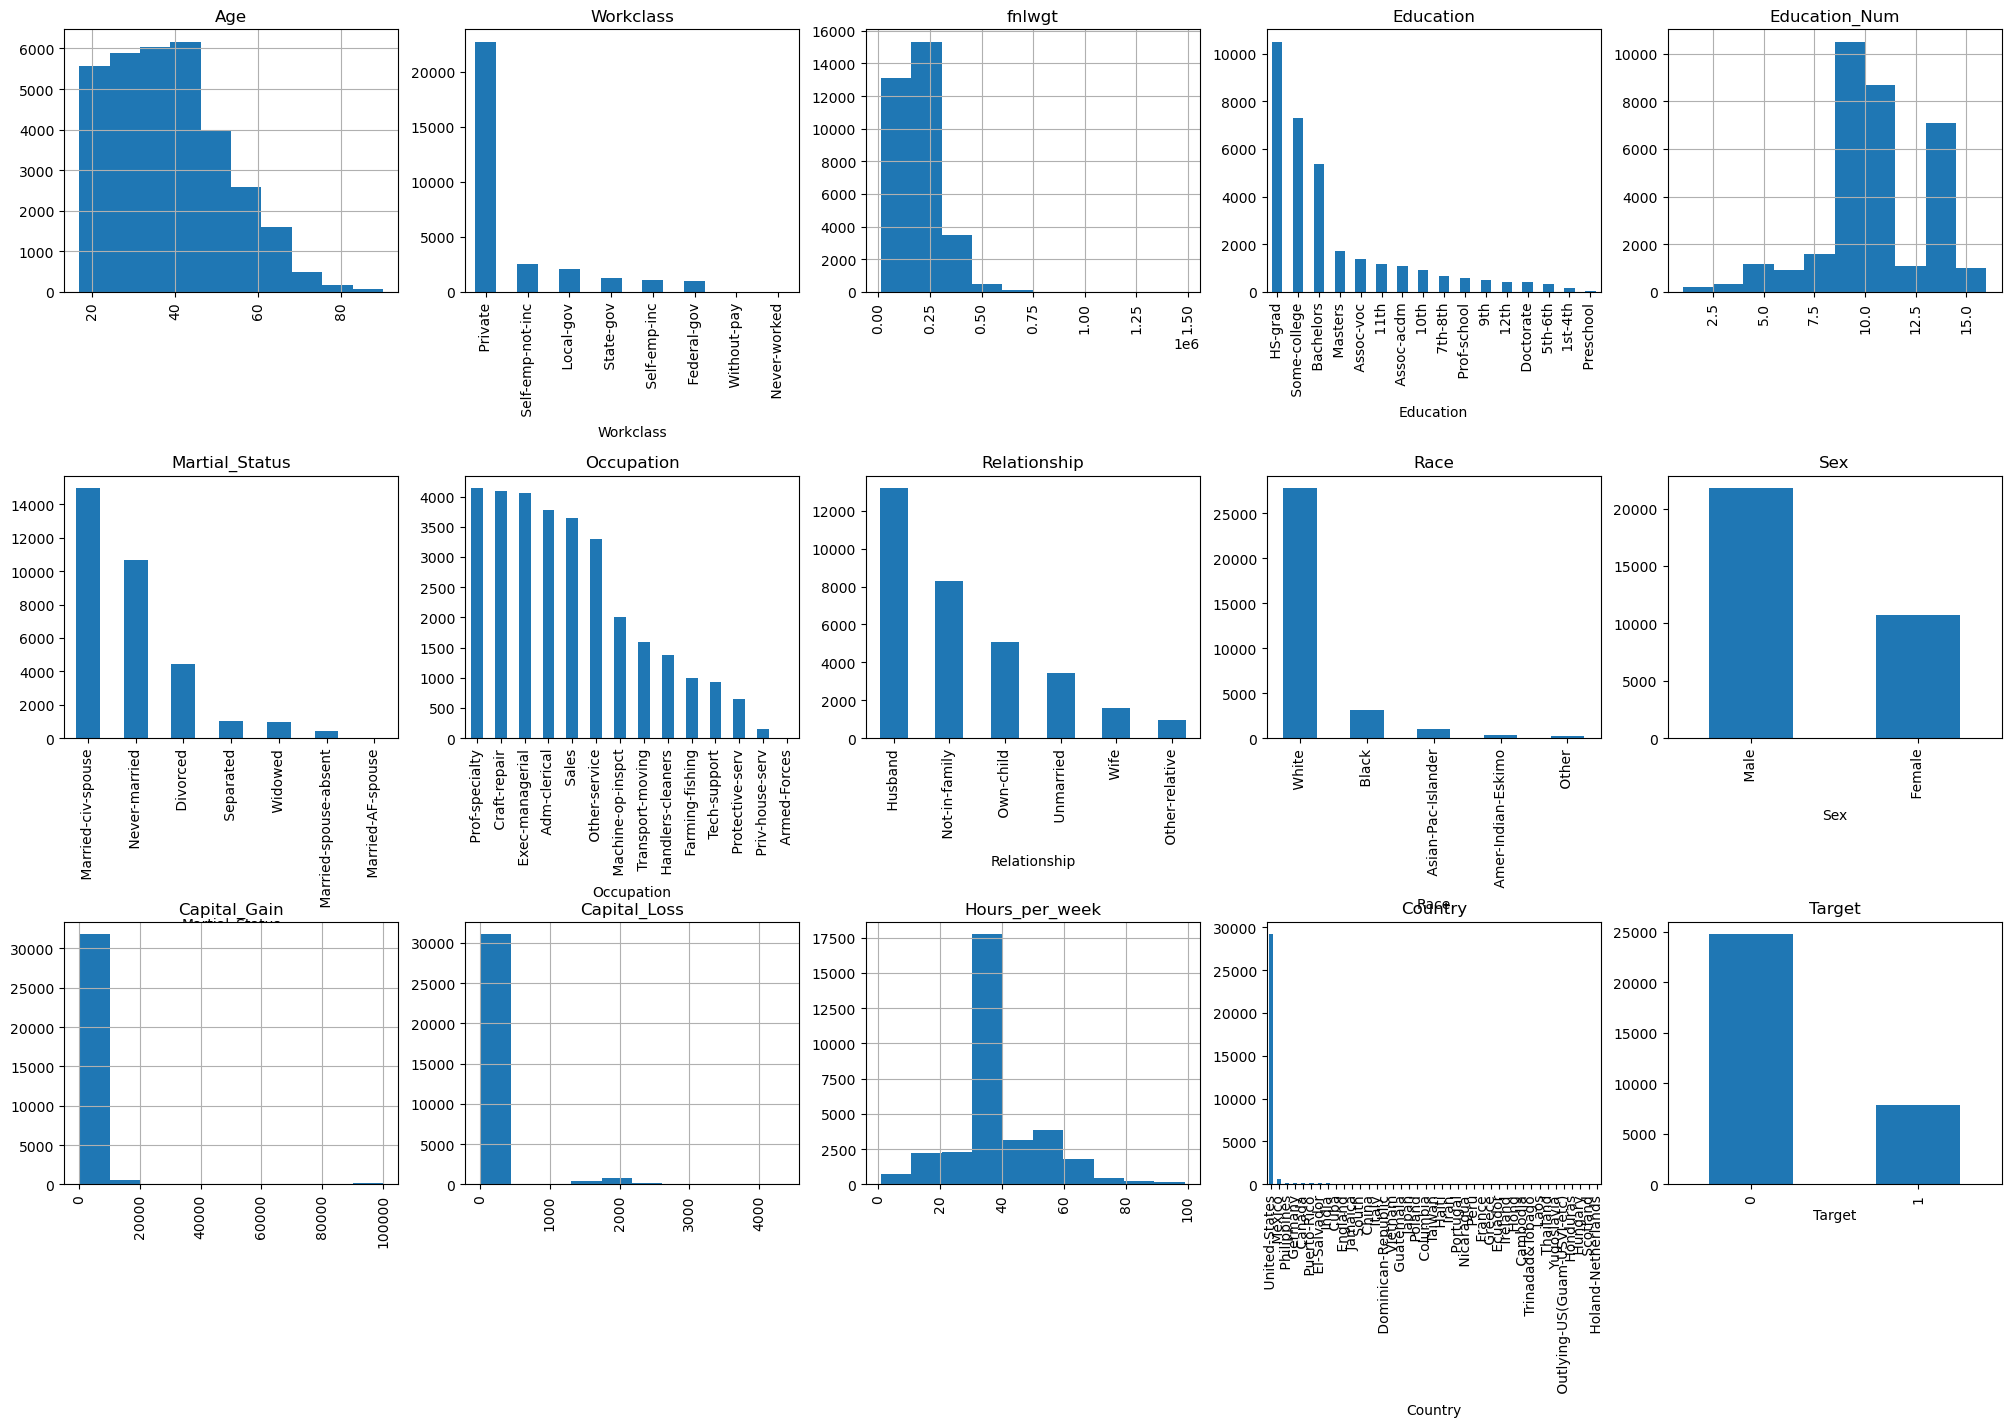

In [25]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

### Checking data types

In [26]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [27]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

As we see, in the test data, age is treated as type object. We need to fix this.

In [28]:
data_test["Age"] = data_test["Age"].astype(int)

Also we’ll cast all float features to int type to keep types consistent between our train and test data.

In [29]:
data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

Save targets separately.

In [30]:
y_train = data_train.pop('Target')
y_test = data_test.pop('Target')

### Fill in missing data for continuous features with their median values, for categorical features with their mode.

In [31]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [32]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [33]:
# fill missing data

for c in categorical_columns:
    data_train.loc[:, c] = data_train[c].fillna(data_train[c].mode()[0])
    data_test.loc[:, c] = data_test[c].fillna(data_train[c].mode()[0])

for c in numerical_columns:
    data_train.loc[:, c] = data_train[c].fillna(data_train[c].median())
    data_test.loc[:, c] = data_test[c].fillna(data_train[c].median())

In [34]:
# no more missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


We’ll dummy code some categorical features: Workclass, Education, Martial_Status, Occupation, Relationship, Race, Sex, Country. It can be done via pandas method get_dummies

In [35]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [36]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [37]:
data_train.shape, data_test.shape

((32561, 105), (16281, 104))

There is no Holland in the test data. Create new zero-valued feature.

In [38]:
data_test["Country_ Holand-Netherlands"] = 0

In [39]:
set(data_train.columns) - set(data_test.columns)

set()

In [40]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [41]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,False,False,False,True,...,False,False,False,False,False,False,True,False,False,0
2,38,89814,9,0,0,50,False,False,False,True,...,False,False,False,False,False,False,True,False,False,0


In [42]:
X_train = data_train
X_test = data_test[X_train.columns]

y_train = y_train.astype('int')
y_test = y_test.astype('int')

### 3.1 Decision tree without parameter tuning

Train a decision tree (DecisionTreeClassifier) with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter random_state = 17 for results reproducibility.

In [43]:
clf_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('clf', DecisionTreeClassifier(
            criterion="entropy",
            max_depth=3,
            random_state=17
        ))
    ]
)

clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        random_state=17))])

In [44]:
y_pred = clf_pipe.predict(X_test)

In [45]:
accu_0 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accu_0:.2f}')

Accuracy: 0.84


### 3.2 Decision tree with parameter tuning

rain a decision tree (DecisionTreeClassifier, random_state = 17). Find the optimal maximum depth using 5-fold cross-validation (GridSearchCV).

In [46]:
clf_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('tree', DecisionTreeClassifier(
            criterion="entropy",
            random_state=17
        ))
    ]
)

tree_params = {"tree__max_depth": range(2, 11)}

locally_best_tree = GridSearchCV(
    clf_pipe,
    tree_params,
    cv=5,
    n_jobs=-1,
    verbose=True
)

locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               random_state=17))]),
             n_jobs=-1, param_grid={'tree__max_depth': range(2, 11)},
             verbose=True)

In [47]:
locally_best_tree.best_params_, locally_best_tree.best_score_

({'tree__max_depth': 8}, 0.8550721982608211)

Train a decision tree with maximum depth of 9 (it is the best max_depth in my case), and compute the test set accuracy. Use parameter random_state = 17 for reproducibility.

In [48]:
tuned_tree = locally_best_tree.best_estimator_

tuned_tree.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=8,
                                        random_state=17))])

7. What is the test set accuracy of a decision tree with maximum depth of 9 and random_state = 17?

In [49]:
tuned_tree_predictions = tuned_tree.predict(X_test)

accu_1 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accu_1:.2f}')

Accuracy: 0.84


### 3.4 (Optional) Random forest with parameter tuning

Train a random forest (RandomForestClassifier). Tune the maximum depth and maximum number of features for each tree using GridSearchCV.

In [50]:
forest_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('forest', RandomForestClassifier(
            criterion="entropy",
            random_state=17
        ))
    ]
)

forest_params = {
    'forest__max_depth': range(10, 21),
    'forest__max_features': range(5, 105, 20)
}

locally_best_forest = GridSearchCV(
    forest_pipe,
    forest_params,
    cv=5,
    n_jobs=-1,
    verbose=True
)

locally_best_forest.fit(X_train, y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('forest',
                                        RandomForestClassifier(criterion='entropy',
                                                               random_state=17))]),
             n_jobs=-1,
             param_grid={'forest__max_depth': range(10, 21),
                         'forest__max_features': range(5, 105, 20)},
             verbose=True)

In [51]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'forest__max_depth': 16, 'forest__max_features': 65}
Best cross validaton score 0.8652685179631288


In [52]:
tuned_forest = locally_best_forest.best_estimator_

tuned_forest.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('forest',
                 RandomForestClassifier(criterion='entropy', max_depth=16,
                                        max_features=65, random_state=17))])

In [53]:
tuned_forest_predictions = tuned_forest.predict(X_test)

accu_2 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accu_2:.2f}')

Accuracy: 0.84
